In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Business Analytics Project

**H<sub>0</sub>:** There is no significant difference in engagement (likes, views, comments, shares) between short songs and longs songs.

**H<sub>A</sub>:** There is a significant difference in engagement (likes, views, comments, shares) between short songs and long songs


- What defines a short/long song?

In [38]:
df = pd.read_csv('Spotify_Youtube.csv')

------------

# Exploratory Data Analysis

In [39]:
df['mins'] = df['Duration_ms'] / 60000 # converts to minutes
df['mins_round'] = round(df['mins']) # rounds minutes 3.74 --> 4.00
grouped_df = df.groupby("mins_round")['Likes'].mean().reset_index() # aggregates data

<b>Engagement variable: 'Likes'</b>

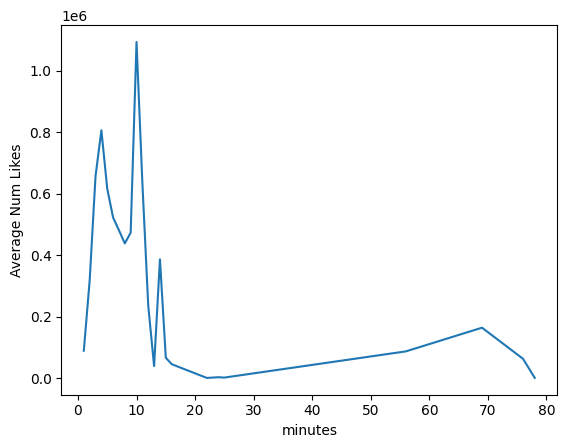

In [40]:
plt.plot(grouped_df['mins_round'], grouped_df['Likes'])
plt.xlabel("minutes")
plt.ylabel("Average Num Likes")
plt.show()

<b>Engagement variable: 'Views'</b>

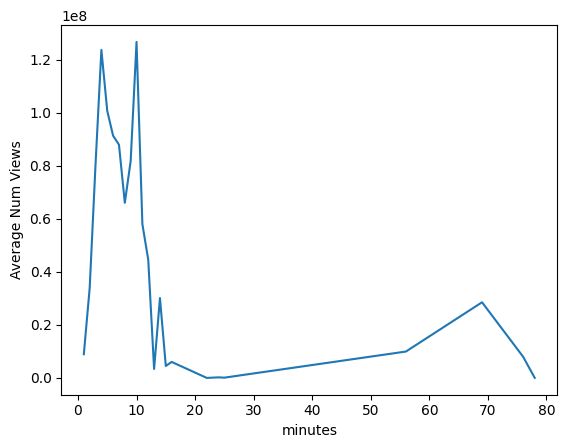

In [41]:
grouped_df = df.groupby("mins_round")['Views'].mean().reset_index() # groups data
plt.plot(grouped_df['mins_round'], grouped_df['Views'])
plt.xlabel("minutes")
plt.ylabel("Average Num Views")
plt.show()

<b>Engagement variable: 'Comments'</b>

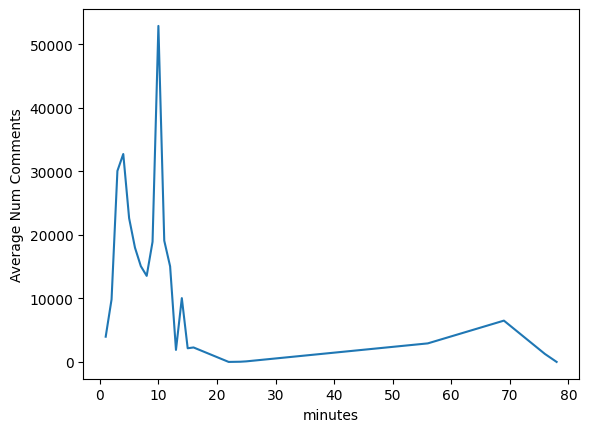

In [42]:
grouped_df = df.groupby("mins_round")['Comments'].mean().reset_index() # groups data
plt.plot(grouped_df['mins_round'], grouped_df['Comments'])
plt.xlabel("minutes")
plt.ylabel("Average Num Comments")
plt.show()

--------

# Exploring Distribution of Numerical Variables

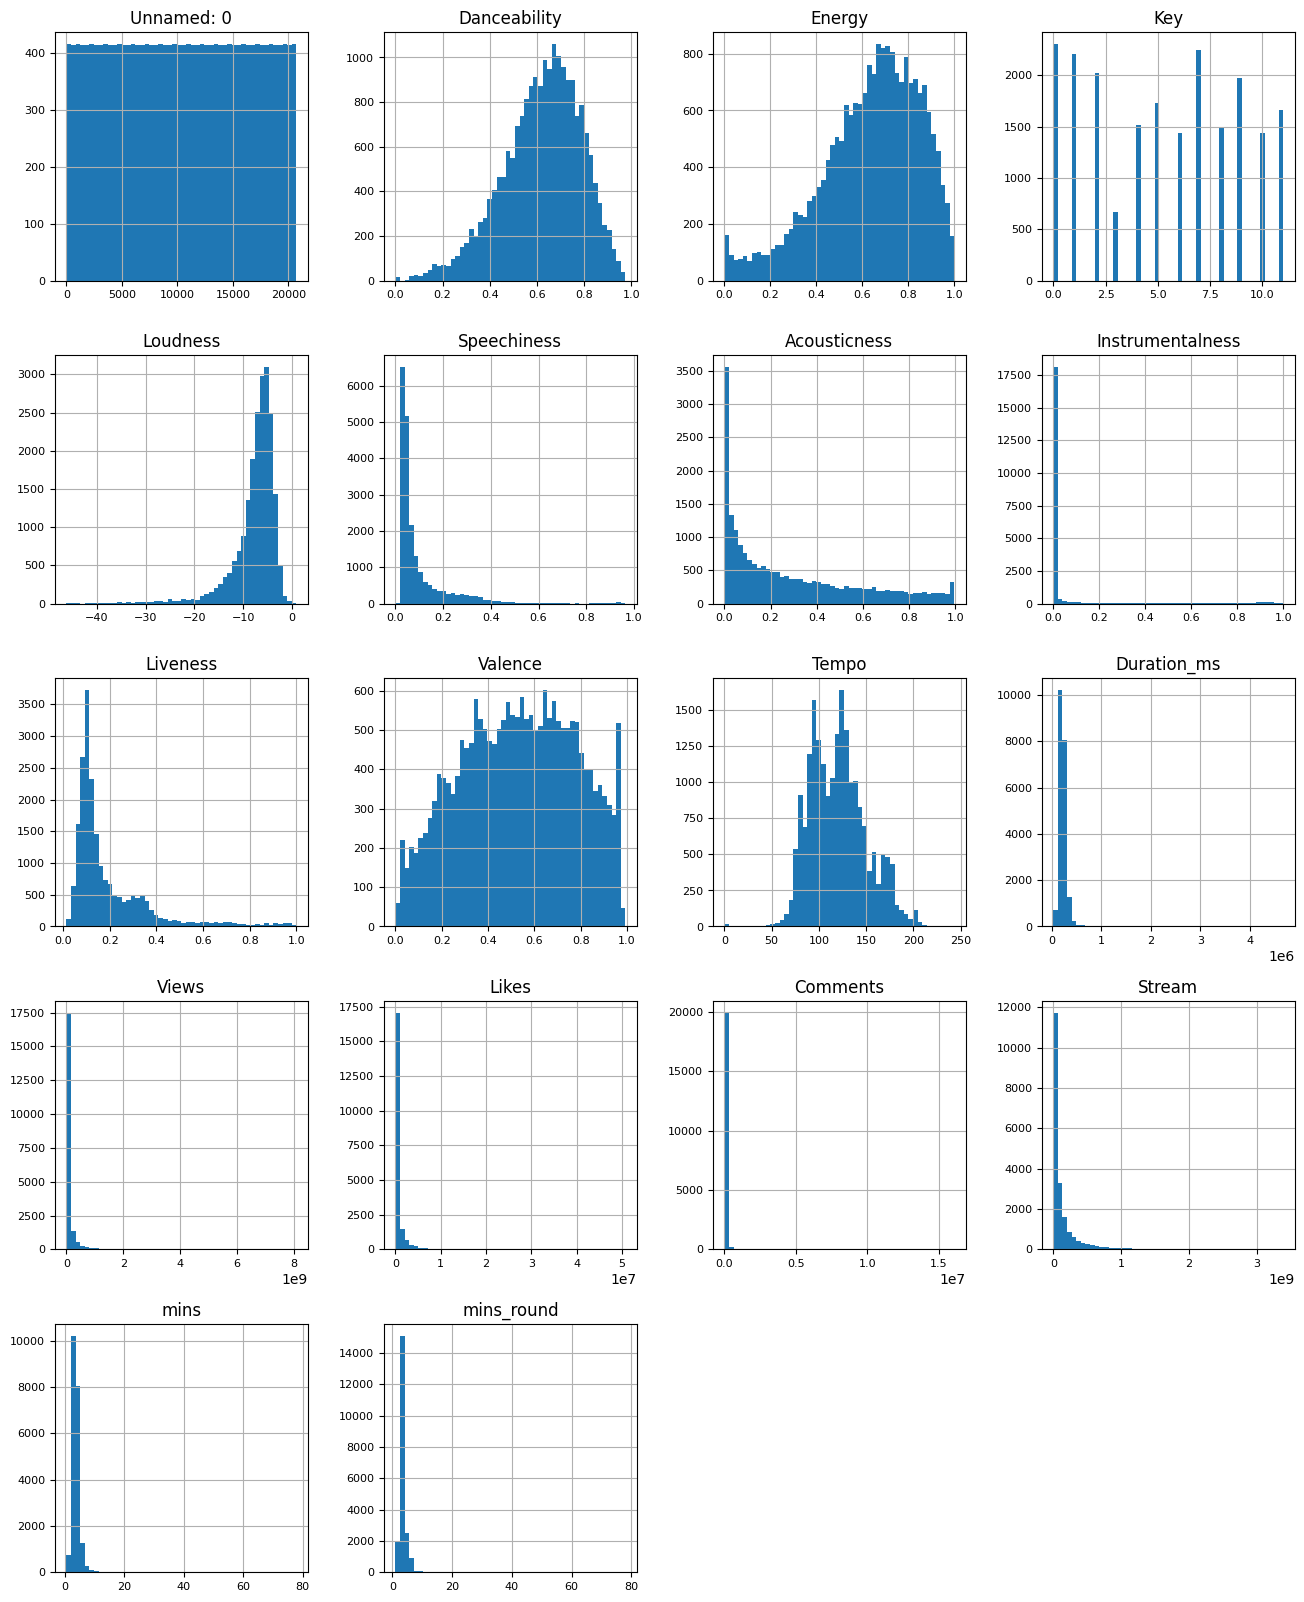

In [43]:
df_num_columns= df.select_dtypes(include=[np.number])
df_num_columns.hist(figsize=(16, 20),bins=50, xlabelsize=8, ylabelsize=8);

# **Randomization Exercise to Find P-value**

**H<sub>0</sub>:** Likes Long Videos - Likes Short Videos = 0

**H<sub>A</sub>:** Likes Long Videos > Likes Short Videos

**Alpha:** 0.05

- What defines a short/long video?


In [44]:
df['mins'] = df['Duration_ms'] / 60000
df['mins_round'] = round(df['mins'])

df.loc[(df['mins'] > 3), 'is_long'] = 'long'
df.loc[(df['mins'] <= 3), 'is_long'] = 'not long'

<b>Cleaning the Data</b>

In [45]:
df_experiment = df[['Likes', 'is_long']]
df_experiment.head()

,Likes,is_long
0,6220896.0,long
1,1079128.0,long
2,282142.0,long
3,1788577.0,long
4,6197318.0,long


In [46]:
to_drop = df_experiment[df_experiment['Likes'] <= 0].index
df_experiment = df_experiment.drop(to_drop)
df_experiment = df_experiment.dropna(subset='Likes')

<b>Proportion of the Data</b>

In [47]:
df_experiment['is_long'].value_counts()

long        15158
not long     5000
Name: is_long, dtype: int64

<b>Average number of likes by group</b>

In [48]:
df_experiment.groupby('is_long')['Likes'].mean()

is_long
long        740420.678322
not long    432154.146400
Name: Likes, dtype: float64

In [49]:
# Point Estimate on the current sample
avg_likes_long_videos = df_experiment[df_experiment['is_long'] == 'long']['Likes'].mean()
avg_likes_short_videos = df_experiment[df_experiment['is_long'] == 'not long']['Likes'].mean()
point_estimate = avg_likes_long_videos - avg_likes_short_videos
point_estimate

308266.5319216783

From this sample we are seeing that, on average, there is a difference in the number of likes between long and short videos. Although this could be simply due to random chance.

In order to verify this, we need a distribution of the sample statistic (avg_likes_long_videos - avg_likes_short_videos) assuming that the null hypothesis is true (**H<sub>0</sub>:** Likes Long Videos - Likes Short Videos = 0)

So assuming that the length of the video has no effect on the number of like, we will randomly choose 12086 "Likes" values and assign it to the "not long" bucket and then we will randomly choose 8612 "Likes" values and assign it to the "long" bucket. As we're assuming that the length of the video has <b>no effect</b> on the number of likes, any difference that we see from the "long" and "not long" buckets will be purely due to random chance. We will do this process 1000 times so we can create a distribution

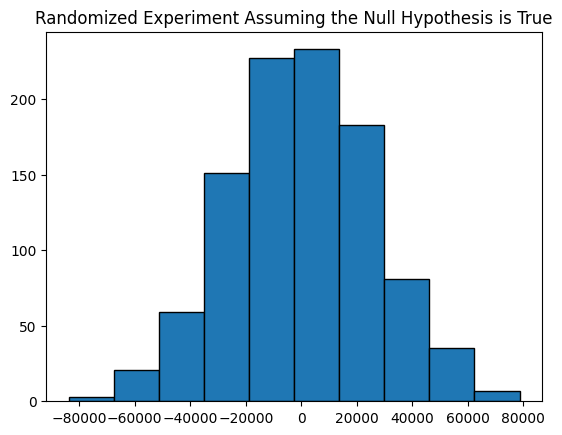

In [50]:
# This code does what's described above
sample = df_experiment['Likes'].tolist()

sampling_distribution = []

for _ in range(1000):

    not_long_sample = np.mean(np.random.choice(sample, size = 11762))
    long_sample = np.mean(np.random.choice(sample, size = 8396))
    sample_statistic = long_sample - not_long_sample
    sampling_distribution.append(sample_statistic)


plt.hist(sampling_distribution, ec='k')
plt.title("Randomized Experiment Assuming the Null Hypothesis is True")
plt.show()


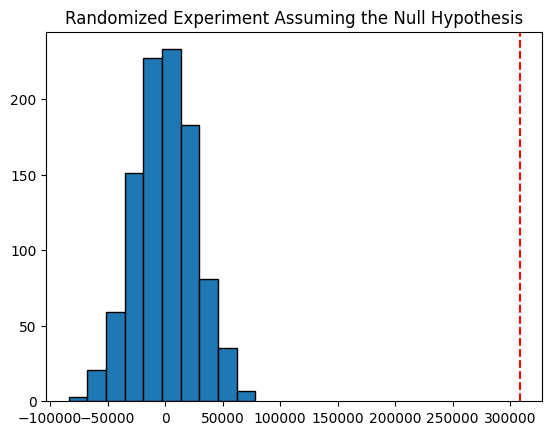

In [51]:
plt.hist(sampling_distribution, ec='k')
plt.title("Randomized Experiment Assuming the Null Hypothesis")
plt.axvline(point_estimate, c='red', linestyle='dashed')
plt.show()

In [52]:
sum([1 for i in sampling_distribution if i >= point_estimate]) / 1000

0.0

With the alpha value was 0.05, we reject the null hypothesis which indicates that length has no effect on number of likes, in favor of the alternative hypothesis which indicates that length has an effect on it. Now that we know this, let's explore deeper using regression analysis

# Regression Analysis

In [53]:
to_drop = ['Unnamed: 0', 'Url_spotify', 'Uri', 'Url_youtube', 'Description', 'Licensed']
df.drop(to_drop, axis=1, inplace=True)

# Distribution of Dependent Variable

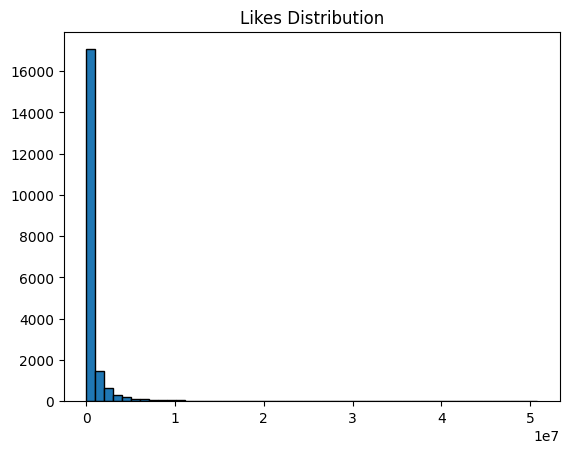

In [54]:
plt.hist(df['Likes'], bins=50, ec='k')
plt.title("Likes Distribution")
plt.show()

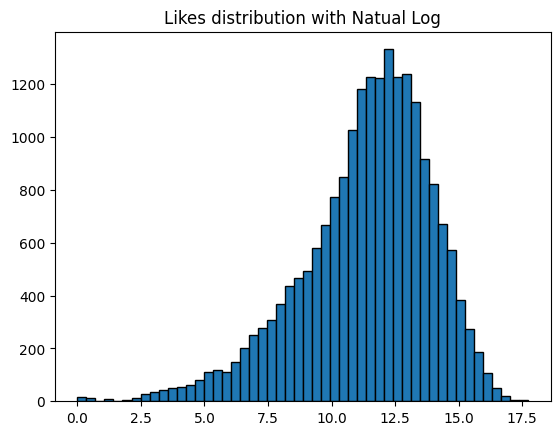

In [55]:
df['Likes'] = df['Likes'] + 1 # getting rid of 0s

plt.hist(np.log(df['Likes']), bins=50, ec='k')
plt.title("Likes distribution with Natual Log")
plt.show()



# Regression 1 - y: Likes, x: minutes

In [56]:
df['mins'] = df['Duration_ms'] / 60000

In [57]:
#linear regression likes and video length (minutes)
import statsmodels.formula.api as smf
df['mins'] = df['Duration_ms'] / 60000
df['mins_round'] = round(df['mins'])
# grouped_df = df.groupby("mins_round")['Likes'].mean().reset_index()
mlr = smf.ols(formula='Likes ~ mins ', data=df).fit()
print(mlr.summary())

                            OLS Regression Results                            
Dep. Variable:                  Likes   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6225
Date:                Sun, 10 Dec 2023   Prob (F-statistic):              0.430
Time:                        00:06:33   Log-Likelihood:            -3.1911e+05
No. Observations:               20176   AIC:                         6.382e+05
Df Residuals:                   20174   BIC:                         6.382e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.456e+05   2.58e+04     25.007      0.0

# Regression 2 - y: Natural Log of Likes, x: minutes

In [58]:
df['Likes'] = df['Likes'] + 1 # getting rid of 0s
df['like_log'] = np.log(df['Likes'])
mlr = smf.ols(formula='like_log ~ mins ', data=df).fit()
print(mlr.summary())

                            OLS Regression Results                            
Dep. Variable:               like_log   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     46.25
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           1.07e-11
Time:                        00:06:36   Log-Likelihood:                -47534.
No. Observations:               20176   AIC:                         9.507e+04
Df Residuals:                   20174   BIC:                         9.509e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.1582      0.037    302.995      0.0

# Regression 3 - y: Natural Log of Likes, x: [minutes, is_long dummy]

In [59]:
df.loc[(df['mins'] > 3.745293), 'is_long'] = 'long'
df.loc[(df['mins'] <= 3.745293), 'is_long'] = 'not long'

mlr = smf.ols(formula='like_log ~ is_long ', data=df).fit()
print(mlr.summary())



                            OLS Regression Results                            
Dep. Variable:               like_log   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     103.5
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           3.01e-24
Time:                        00:06:39   Log-Likelihood:                -47506.
No. Observations:               20176   AIC:                         9.502e+04
Df Residuals:                   20174   BIC:                         9.503e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              11.5930    

# Regression 4 - y: Natural Log of Likes, x: [time_quartile dummie] - HERE!!!

In [60]:
# Leaving 25 percentile as our base
df['mins'].fillna(df['mins'].mean(), inplace=True)

# Assuming df is your DataFrame
percentile_25 = np.percentile(df['mins'], 25)
percentile_50 = np.percentile(df['mins'], 50)
percentile_75 = np.percentile(df['mins'], 75)

df['percentile_50'] = np.where((df['mins'] >= percentile_25) & (df['mins'] < percentile_50), 1, 0)
df['percentile_75'] = np.where((df['mins'] >= percentile_50) & (df['mins'] < percentile_75), 1, 0)
df['percentile_100'] = np.where(df['mins'] >= percentile_75, 1, 0)

In [61]:
mlr = smf.ols(formula='like_log ~ percentile_50+percentile_75+percentile_100 ', data=df).fit()
print(mlr.summary())

                            OLS Regression Results                            
Dep. Variable:               like_log   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     165.2
Date:                Sun, 10 Dec 2023   Prob (F-statistic):          8.32e-106
Time:                        00:06:43   Log-Likelihood:                -47314.
No. Observations:               20177   AIC:                         9.464e+04
Df Residuals:                   20173   BIC:                         9.467e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         10.7206      0.036    300.

**$$\text{like_log} = 10.7206 + 0.7954 \times \text{percentile_50} + 1.0670 \times \text{percentile_75} + 0.7556 \times \text{percentile_100}$$**



**The percentile_75 seems like the time that increases the like_log the most**








In [62]:
def predict_like_log(percentile_50, percentile_75, percentile_100):
    # Coefficients
    intercept = 10.7206
    coef_percentile_50 = 0.7954
    coef_percentile_75 = 1.0670
    coef_percentile_100 = 0.7556

    # Calculate the predicted value in the log scale
    log_prediction = intercept + coef_percentile_50 * percentile_50 + coef_percentile_75 * percentile_75 + coef_percentile_100 * percentile_100

    # Revert the natural log transformation
    original_prediction = np.exp(log_prediction)

    return original_prediction

In [63]:
# percentile 25
predict_like_log(percentile_50=0, percentile_75=0, percentile_100=0)

45279.062130639504

In [64]:
# percentile 50
predict_like_log(percentile_50=1, percentile_75=0, percentile_100=0)

100307.92662601316

In [65]:
# percentile 75
predict_like_log(percentile_50=0, percentile_75=1, percentile_100=0)

131610.22599715227

In [66]:
# percentile 100
predict_like_log(percentile_50=0, percentile_75=0, percentile_100=1)

96394.07345247698

In [67]:
print(f"Perfect time length for your video in order to maximize likes is from {round(percentile_50,2)} to {round(percentile_75,2)} minutes")

Perfect time length for your video in order to maximize likes is from 3.55 to 4.21 minutes


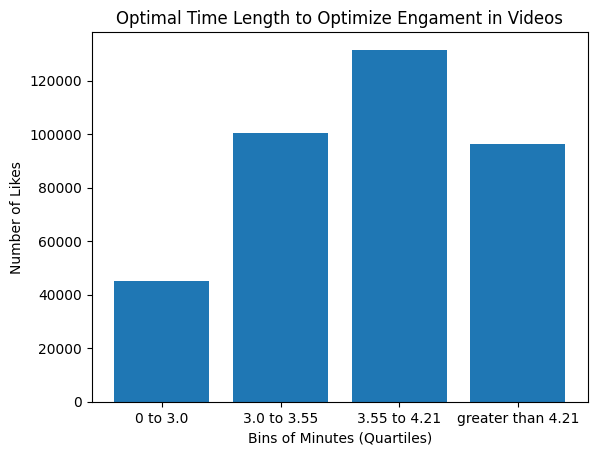

In [68]:
times = [45279.062130639504, 100307.92662601316, 131610.22599715227, 96394.07345247698]
time_in_mins = [f"{0} to {round(percentile_25,2)}", f"{round(percentile_25,2)} to {round(percentile_50,2)}",
                f"{round(percentile_50,2)} to {round(percentile_75,2)}", f"greater than {round(percentile_75,2)}"]

plt.bar(time_in_mins, times)
plt.title("Optimal Time Length to Optimize Engament in Videos")
plt.ylabel("Number of Likes")
plt.xlabel("Bins of Minutes (Quartiles)")
plt.show()

Our regression predicts that a song with a duration between 3.55 to 4.12 minutes will bring in the highest number of likes at an estimate of 131,610 likes

## Let's throw other variables to the model, interaction terms

In [69]:
mlr = smf.ols(formula='like_log ~ percentile_75+Loudness+Loudness:percentile_75 ', data=df).fit()
print(mlr.summary())

                            OLS Regression Results                            
Dep. Variable:               like_log   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     789.6
Date:                Sun, 10 Dec 2023   Prob (F-statistic):               0.00
Time:                        00:06:53   Log-Likelihood:                -46437.
No. Observations:               20176   AIC:                         9.288e+04
Df Residuals:                   20172   BIC:                         9.291e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 12



---



---

